In [49]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from skimage import exposure

In [50]:
def match_intensity_distribution(target_image, original_image):
    # Filter out zero pixels
    target_image_nonzero = target_image[target_image > 0]
    original_image_nonzero = original_image[original_image > 0]

    # Match the histograms
    matched_intensities = exposure.match_histograms(target_image_nonzero, original_image_nonzero)

    # Create a new array of the same shape as the original image
    matched_image = np.zeros_like(original_image)

    # Replace the non-zero pixels in the new array with the matched intensities
    matched_image[target_image > 0] = matched_intensities

    return matched_image

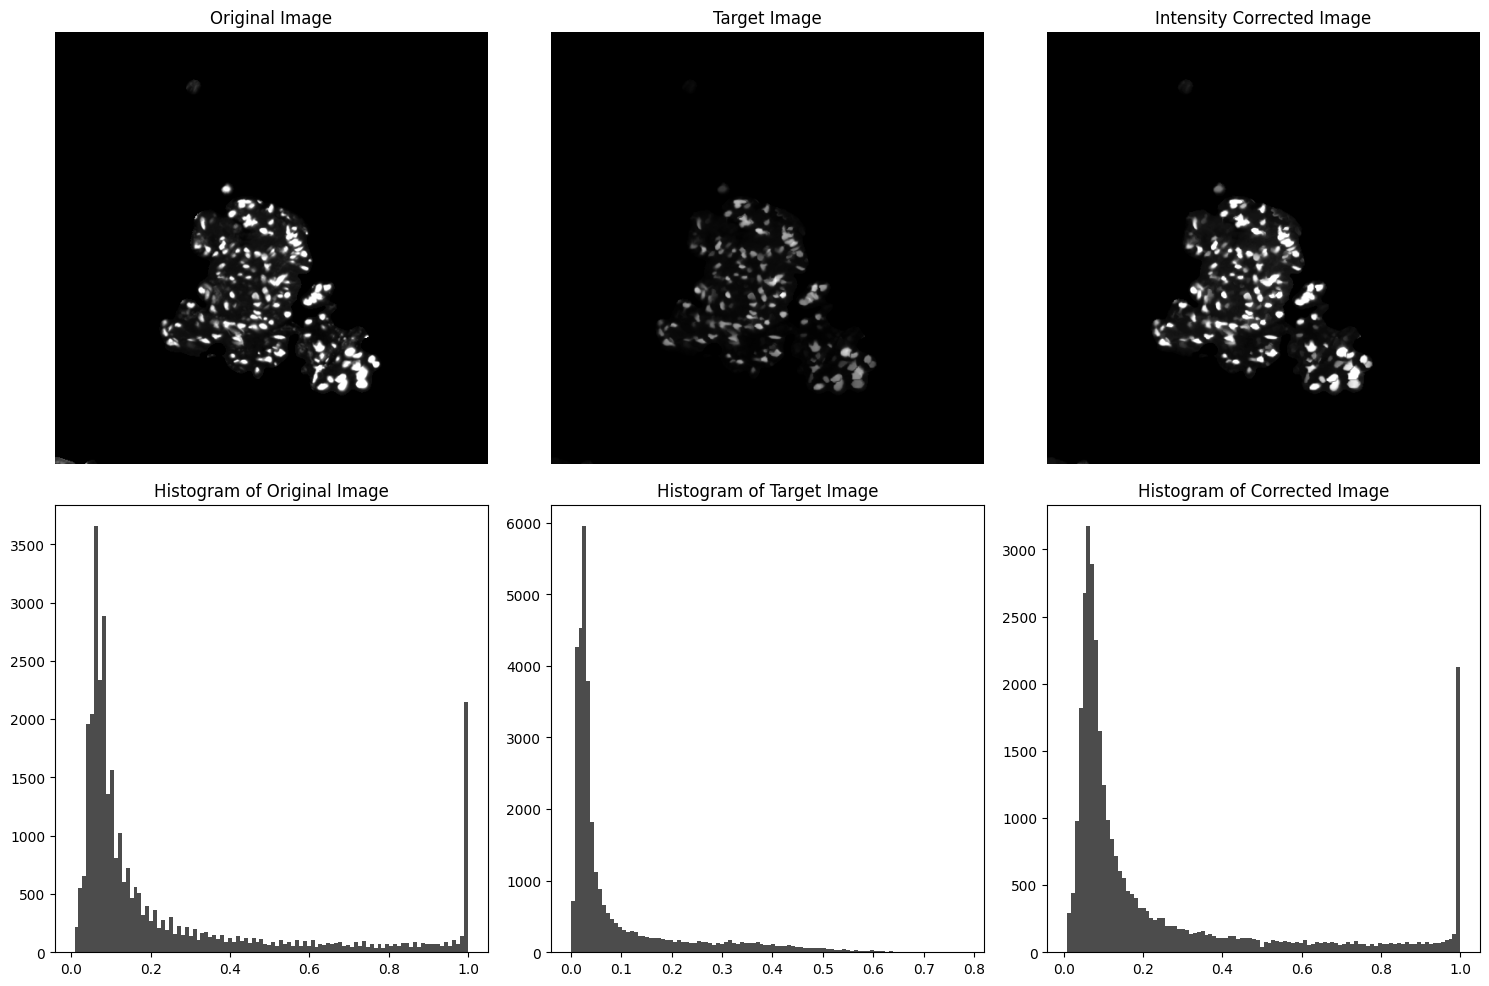

In [51]:
original_image = np.load('/home-local/rudravg/test_DAPI/testing_it_out/original_image.npy')
target_image = np.load('/home-local/rudravg/test_DAPI/testing_it_out/moved_img.npy')

matched_image= match_intensity_distribution(target_image, original_image)
matched_image = matched_image.reshape(original_image.shape)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0, 0].imshow(original_image, cmap='gray')
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

axs[0, 1].imshow(target_image, cmap='gray')
axs[0, 1].set_title('Target Image')
axs[0, 1].axis('off')

axs[0, 2].imshow(matched_image, cmap='gray')
axs[0, 2].set_title('Intensity Corrected Image')
axs[0, 2].axis('off')

axs[1, 0].hist(original_image[original_image > 0].ravel(), bins=100, color='black', alpha=0.7)
axs[1, 0].set_title('Histogram of Original Image')

axs[1, 1].hist(target_image[target_image > 0].ravel(), bins=100, color='black', alpha=0.7)
axs[1, 1].set_title('Histogram of Target Image')

axs[1, 2].hist(matched_image[matched_image > 0].ravel(), bins=100, color='black', alpha=0.7)
axs[1, 2].set_title('Histogram of Corrected Image')

plt.tight_layout()
plt.show()

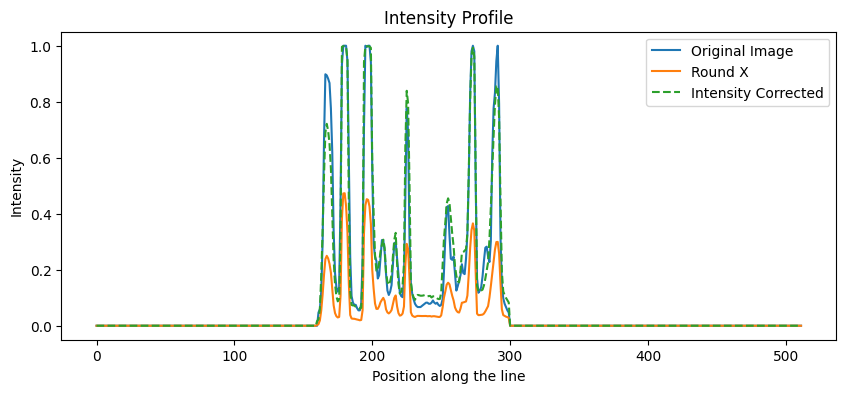

In [53]:
x = np.linspace(0, original_image.shape[1] - 1, original_image.shape[1])
y = np.full(original_image.shape[1], original_image.shape[0] // 2)

# Get the intensities along the line in the original and target images
original_intensities = original_image[y.astype(int), x.astype(int)]
target_intensities = target_image[y.astype(int), x.astype(int)]

matched_intensities = matched_image[y.astype(int), x.astype(int)]

plt.figure(figsize=(10, 4))
plt.plot(x, original_intensities, label='Original Image', alpha=1)
plt.plot(x, target_intensities, label='Round X', alpha=1)
plt.plot(x, matched_intensities, label='Intensity Corrected', alpha=1, linestyle='--')
plt.title('Intensity Profile')
plt.xlabel('Position along the line')
plt.ylabel('Intensity')
plt.legend()
plt.show()

In [29]:
from scipy.optimize import least_squares

def polynomial_gain_field(x, y, coeffs):
    """Calculate the gain field as a polynomial function of the pixel coordinates."""
    return coeffs[0] + coeffs[1]*x + coeffs[2]*y + coeffs[3]*x*y + coeffs[4]*x**2 + coeffs[5]*y**2

def residuals(coeffs, target_image, original_image):
    """Calculate the residuals of the gain field model."""
    x, y = np.meshgrid(np.arange(target_image.shape[1]), np.arange(target_image.shape[0]))
    gain_field = polynomial_gain_field(x, y, coeffs)
    residuals = (gain_field * target_image - original_image)
    return residuals[target_image > 0].ravel()

def correct_intensities(target_image, original_image):
    """Correct the intensities of the target image using a gain field."""
    # Initial guess for the coefficients of the polynomial
    coeffs0 = np.zeros(6)

    # Fit the gain field to the images
    res = least_squares(residuals, coeffs0, args=(target_image, original_image))

    # Apply the gain field to the target image
    x, y = np.meshgrid(np.arange(target_image.shape[1]), np.arange(target_image.shape[0]))
    gain_field = polynomial_gain_field(x, y, res.x)
    corrected_image = gain_field * target_image

    return corrected_image

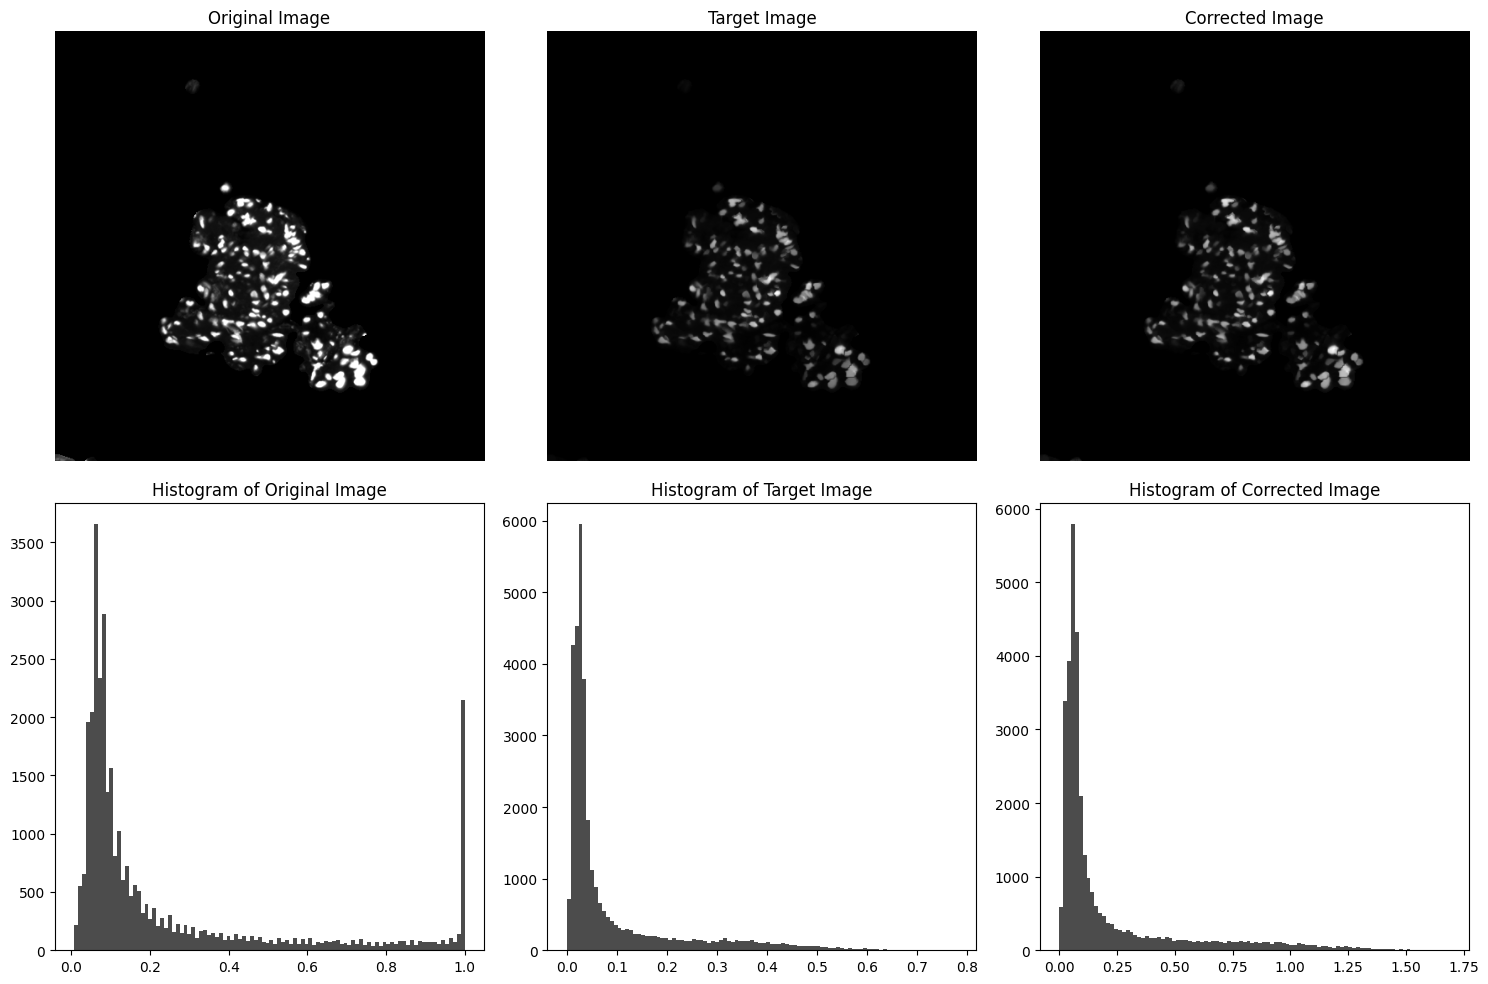

In [30]:
matched_image_new= correct_intensities(target_image, original_image)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0, 0].imshow(original_image, cmap='gray')
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

axs[0, 1].imshow(target_image, cmap='gray')
axs[0, 1].set_title('Target Image')
axs[0, 1].axis('off')

axs[0, 2].imshow(matched_image_new, cmap='gray')
axs[0, 2].set_title('Corrected Image')
axs[0, 2].axis('off')

axs[1, 0].hist(original_image[original_image > 0].ravel(), bins=100, color='black', alpha=0.7)
axs[1, 0].set_title('Histogram of Original Image')

axs[1, 1].hist(target_image[target_image > 0].ravel(), bins=100, color='black', alpha=0.7)
axs[1, 1].set_title('Histogram of Target Image')

axs[1, 2].hist(matched_image_new[matched_image_new > 0].ravel(), bins=100, color='black', alpha=0.7)
axs[1, 2].set_title('Histogram of Corrected Image')

plt.tight_layout()
plt.show()

In [32]:
from scipy.ndimage import gaussian_filter

def smooth_and_match_intensities(target_image, original_image, sigma):
    """Smooth the images and match the intensities."""
    # Smooth the images
    target_image_smooth = gaussian_filter(target_image, sigma)
    original_image_smooth = gaussian_filter(original_image, sigma)

    # Calculate the mean and standard deviation of the non-zero pixels in the smoothed images
    target_image_nonzero = target_image_smooth[target_image_smooth > 0]
    original_image_nonzero = original_image_smooth[original_image_smooth > 0]
    mu_t, sigma_t = np.mean(target_image_nonzero), np.std(target_image_nonzero)
    mu_o, sigma_o = np.mean(original_image_nonzero), np.std(original_image_nonzero)

    # Match the intensities
    matched_image = (target_image - mu_t) * (sigma_o / sigma_t) + mu_o

    return matched_image

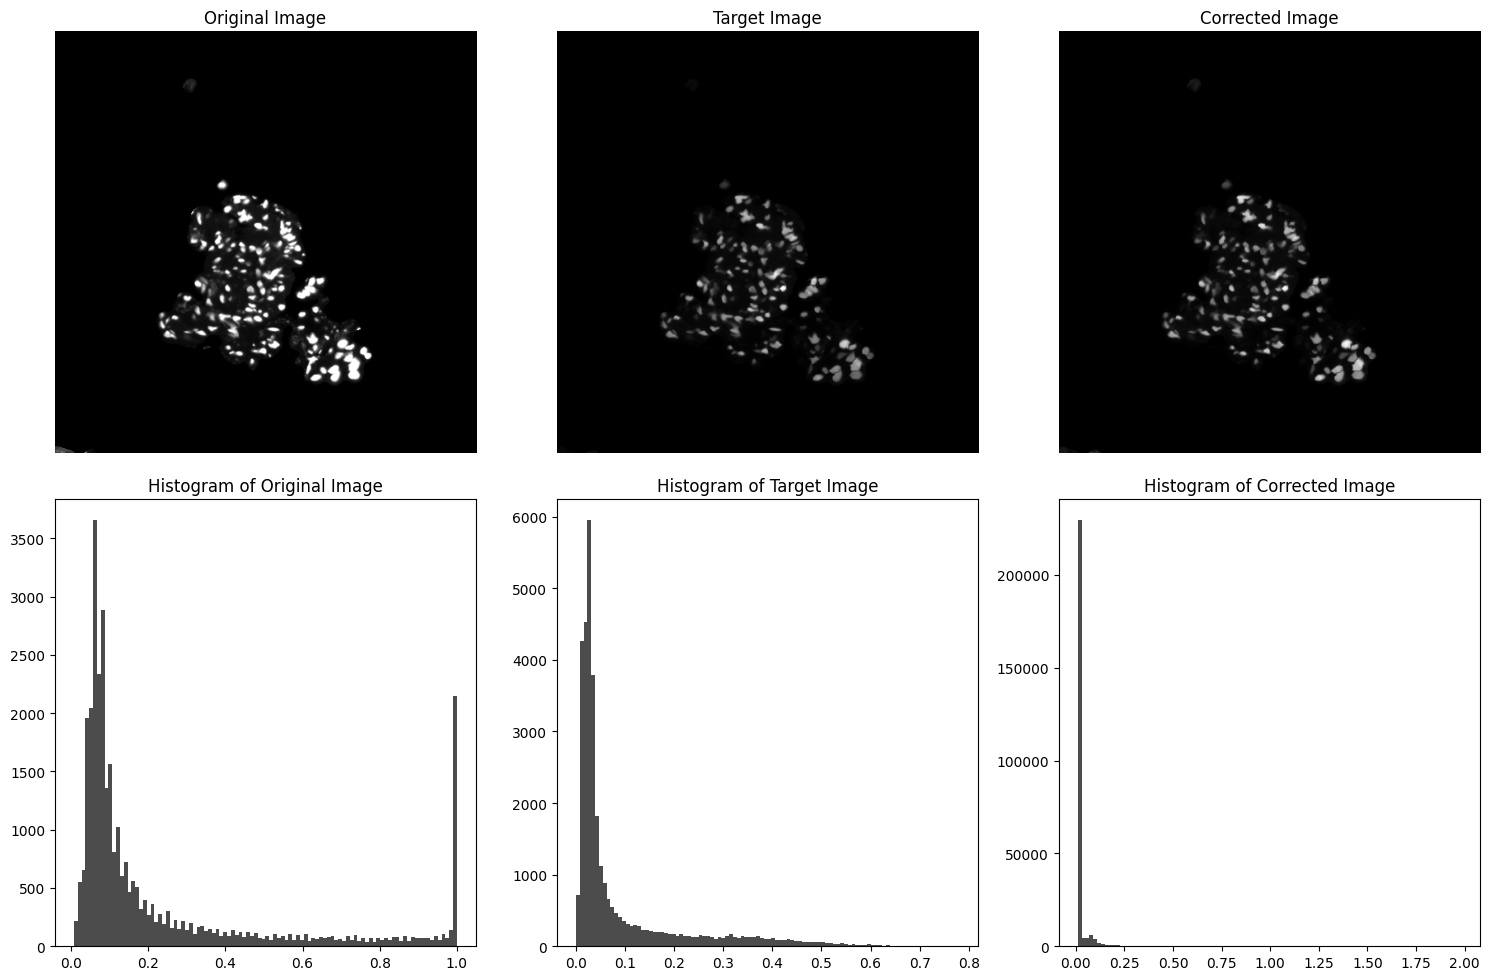

In [40]:
matched_image_smooth= smooth_and_match_intensities(target_image, original_image,5)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0, 0].imshow(original_image, cmap='gray')
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

axs[0, 1].imshow(target_image, cmap='gray')
axs[0, 1].set_title('Target Image')
axs[0, 1].axis('off')

axs[0, 2].imshow(matched_image_new, cmap='gray')
axs[0, 2].set_title('Corrected Image')
axs[0, 2].axis('off')

axs[1, 0].hist(original_image[original_image > 0].ravel(), bins=100, color='black', alpha=0.7)
axs[1, 0].set_title('Histogram of Original Image')

axs[1, 1].hist(target_image[target_image > 0].ravel(), bins=100, color='black', alpha=0.7)
axs[1, 1].set_title('Histogram of Target Image')

axs[1, 2].hist(matched_image_smooth[matched_image_smooth > 0].ravel(), bins=100, color='black', alpha=0.7)
axs[1, 2].set_title('Histogram of Corrected Image')

plt.tight_layout()
plt.show()

In [43]:
import numpy as np
from numpy.polynomial.chebyshev import chebfit, chebval
from scipy.optimize import least_squares

def residuals_cheb(coeffs, target_image, original_image):

    x, y = np.meshgrid(np.arange(target_image.shape[1]), np.arange(target_image.shape[0]))
    gain_field = chebval(x, coeffs) * chebval(y, coeffs)
    residuals = (gain_field * target_image - original_image)
    return residuals[target_image > 0].ravel()

def correct_intensities_cheb(target_image, original_image, degree):
    """Correct the intensities of the target image using a Chebyshev polynomial gain field."""
    # Initial guess for the coefficients of the polynomial
    coeffs0 = np.zeros(degree + 1)

    # Fit the gain field to the images
    res = least_squares(residuals_cheb, coeffs0, args=(target_image, original_image))

    # Apply the gain field to the target image
    x, y = np.meshgrid(np.arange(target_image.shape[1]), np.arange(target_image.shape[0]))
    gain_field = chebval(x, res.x) * chebval(y, res.x)
    corrected_image = gain_field * target_image

    return corrected_image

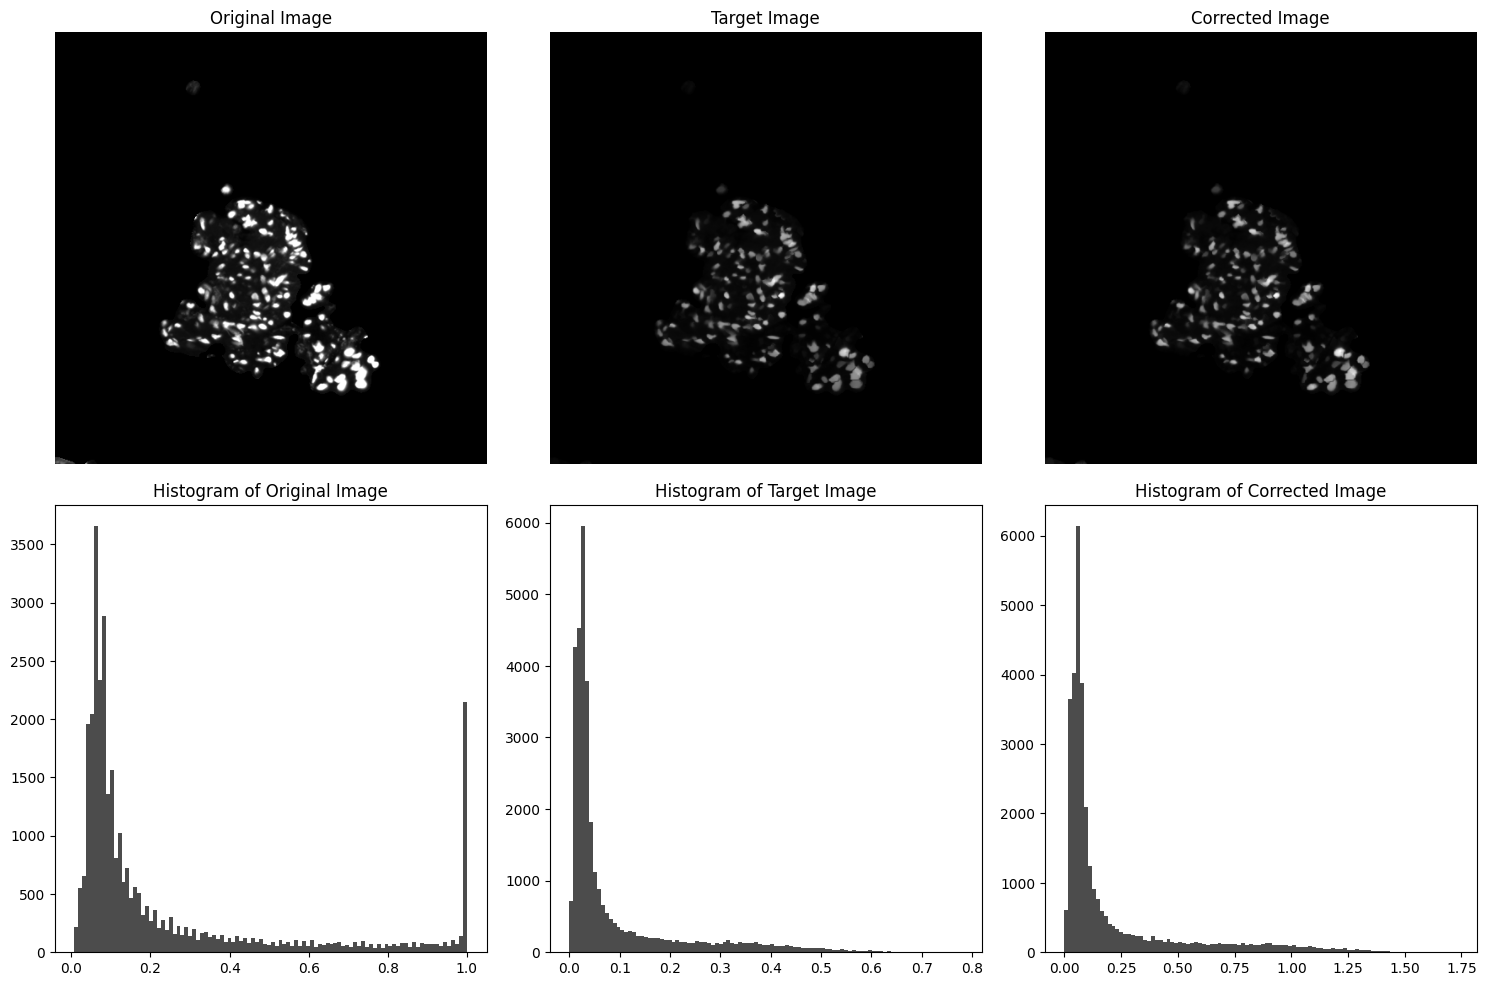

In [48]:
matched_image_smooth= correct_intensities_cheb(target_image, original_image,2)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0, 0].imshow(original_image, cmap='gray')
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

axs[0, 1].imshow(target_image, cmap='gray')
axs[0, 1].set_title('Target Image')
axs[0, 1].axis('off')

axs[0, 2].imshow(matched_image_smooth, cmap='gray')
axs[0, 2].set_title('Corrected Image')
axs[0, 2].axis('off')

axs[1, 0].hist(original_image[original_image > 0].ravel(), bins=100, color='black', alpha=0.7)
axs[1, 0].set_title('Histogram of Original Image')

axs[1, 1].hist(target_image[target_image > 0].ravel(), bins=100, color='black', alpha=0.7)
axs[1, 1].set_title('Histogram of Target Image')

axs[1, 2].hist(matched_image_smooth[matched_image_smooth > 0].ravel(), bins=100, color='black', alpha=0.7)
axs[1, 2].set_title('Histogram of Corrected Image')

plt.tight_layout()
plt.show()